# Debug fit

In [276]:
import numpy as np
from matplotlib import pyplot as plt
import stan_utility
import corner
import h5py
import os

## Simple simulation
Simulate detected energies from a single source with a given $L$, $\alpha$ and $D$.

In [277]:
from astropy import units as u
from python.source.simple_source import icrs_to_uv
from python.source.simple_source import PointSource, TestSourceList
from python.source.flux_model import PowerLawSpectrum
from python.source.parameter import Parameter

In [278]:
# Define point source params
Parameter.clear_registry()
index = Parameter(2.6, "index", fixed=False, par_range=(1.0, 4))
luminosity = Parameter(5E47 * (u.erg / u.s), "luminosity", fixed=True, 
                       par_range=(0, 1E60))

# Loading from file
source_file = '../dev/statistical_model/data/test_SFR_pop.h5'
source_list = TestSourceList(source_file, luminosity, index, 1E5 * u.GeV, 1E8 * u.GeV)
source_list.select_below_redshift(0.46)


# Edit for testing
source_list.sources[0].dec = np.deg2rad(10) * u.rad
source_list.sources[0].ra = np.deg2rad(180) * u.rad

In [279]:
source = source_list.sources[0]
source.flux_model.total_flux_int

<Quantity 1.83827848e-08 1 / (m2 s)>

In [280]:
from python.precomputation import ExposureIntegral
from python.detector_model import NorthernTracksDetectorModel

In [281]:
Emin_det = 1.0e5 * u.GeV # GeV
Esrc_min = 1.0e5 * u.GeV
Esrc_max = 1.0e8 * u.GeV

exposure_integral = ExposureIntegral(source_list, 
                                     NorthernTracksDetectorModel, 
                                     Emin_det, Esrc_min, Esrc_max)

exposure_integral()

In [282]:
from python.backend.stan_generator import (
    StanGenerator, GeneratedQuantitiesContext, DataContext, TransformedDataContext,
    FunctionsContext, Include, ForLoopContext, StanFileGenerator, WhileLoopContext, FunctionCall, ModelContext, IfBlockContext, ElseIfBlockContext, ElseBlockContext)
from python.backend.variable_definitions import ForwardVariableDef, ForwardArrayDef
from python.backend.expression import StringExpression
from python.backend.parameterizations import DistributionMode
import logging
logger = logging.getLogger("python.backend.code_generator")
logger.disabled = True

In [283]:
with StanFileGenerator("stan_files/simple_sim") as simple_sim_gen:
    with FunctionsContext():
        _ = Include("utils.stan")
        _ = Include("vMF.stan")
        _ = Include("interpolation.stan")
        _ = Include("sim_functions.stan")
        spec_rng = source.flux_model.spectral_shape.make_stan_sampling_func("spec_rng")
        F_conv = source.flux_model.spectral_shape.make_stan_flux_conv_func("flux_conv")
    
    with DataContext():
        alpha = ForwardVariableDef("alpha", "real")
        L = ForwardVariableDef("L", "real")
        D = ForwardVariableDef("D", "real")
        redshift = ForwardVariableDef("redshift", "real")
        #varpi = ForwardVariableDef("varpi", "unit_vector[3]")
        
        T = ForwardVariableDef("T", "real")
        #Edet_min = ForwardVariableDef("Edet_min", "real")
        Esrc_min = ForwardVariableDef("Esrc_min", "real")
        Esrc_max = ForwardVariableDef("Esrc_max", "real")
        
        Ngrid = ForwardVariableDef("Ngrid", "int")
        alpha_grid = ForwardVariableDef("alpha_grid", "vector[Ngrid]")
        integral_grid = ForwardVariableDef("integral_grid", "vector[Ngrid]")
        #aeff_max = ForwardVariableDef("aeff_max", "real")
        
    with TransformedDataContext():
        
        F = ForwardVariableDef("F", "real")
        D_m = ForwardVariableDef("D_m", "real")
        eps = ForwardVariableDef("eps", "real")
        Nex = ForwardVariableDef("Nex", "real")
        N = ForwardVariableDef("N", "int")
        
        D_m << D * 3.086e22
        F << StringExpression([L, "/ (4 * pi() * pow(", D_m, ", 2))"])
        F << F * F_conv(alpha, Esrc_min, Esrc_max)
        
        eps << FunctionCall([alpha, alpha_grid, integral_grid, T], "get_eps_simple")
        Nex << F * eps

        N << FunctionCall([Nex], "poisson_rng")
        StringExpression(["print(", Ngrid, ")"])
        
    with GeneratedQuantitiesContext():
        ntd_rng = NorthernTracksDetectorModel(mode=DistributionMode.RNG)
        ntd_pdf = NorthernTracksDetectorModel(mode=DistributionMode.PDF) 

        N_str = ["[", N, "]"]
        #accept = ForwardVariableDef("accept", "int")
        #detect = ForwardVariableDef("detect", "int")
        #Pdet = ForwardArrayDef("Pdet", "real", N_str)
        #prob = ForwardVariableDef("prob", "simplex[2]")
        Esrc = ForwardVariableDef("Esrc", "vector[N]")
        E = ForwardVariableDef("E", "vector[N]")
        #Edet = ForwardVariableDef("Edet", "vector[N]")
        
        with ForLoopContext(1, N, "i") as i:
            #accept << 0
            #with WhileLoopContext([StringExpression([accept != 1])]):
            Esrc[i] << spec_rng(alpha, Esrc_min, Esrc_max)
            E[i] << Esrc[i] / (1 + redshift)
                #Pdet[i] << ntd_pdf.effective_area(E[i], varpi) / aeff_max
                #Edet[i] << 10**ntd_rng.energy_resolution(E[i])
                #prob[1] << Pdet[i]
                #prob[2] << 1 - Pdet[i]
                #accept << FunctionCall([prob], "categorical_rng")
                #with IfBlockContext([StringExpression(["(", Edet[i], " >= ",
                #                                       Edet_min, ") && (", 
                #                                       detect == 1, ")"])]):
                #    accept << 1        
            
    simple_sim_gen.generate_single_file()

In [284]:
this_dir = os.path.abspath('')
include_paths = [os.path.join(this_dir, "stan_files/")]
sim = stan_utility.compile_model(filename=simple_sim_gen.filename, 
                                 include_paths=include_paths, 
                                 model_name="sim")

Using cached StanModel


In [285]:
from python.source.cosmology import luminosity_distance

In [286]:
# Inputs 
sim_inputs = {}
sim_inputs["L"] = source.luminosity.to(u.GeV/u.s).value
sim_inputs['redshift'] = source.redshift
sim_inputs['D'] = luminosity_distance(source.redshift).value
sim_inputs['varpi'] = icrs_to_uv(source.dec.value, source.ra.value)

sim_inputs['Ngrid'] = len(exposure_integral.par_grids["index"])
sim_inputs['alpha_grid'] = exposure_integral.par_grids["index"]
sim_inputs['integral_grid'] = [_.value for _ in exposure_integral.integral_grid][0]
sim_inputs["T"] =  (8 * u.year).to(u.s) 

sim_inputs['alpha'] = index.value
sim_inputs['Edet_min'] = 1e5 # GeV
sim_inputs["Esrc_min"] = 1e5 # GeV
sim_inputs["Esrc_max"] = 1e8 # GeV

# Set maximum based on Esrc_max to speed up rejection sampling
# Could improve this with HMC sampling?
lbe = exposure_integral.effective_area._tE_bin_edges[:-1]
Esrc_max = sim_inputs["Esrc_max"]
aeff_max = np.max(exposure_integral.effective_area._eff_area[lbe < Esrc_max][:])
sim_inputs['aeff_max'] = aeff_max

In [287]:
# Simulate
simulation = sim.sampling(data=sim_inputs, iter=1, chains=1, 
                         algorithm="Fixed_param")

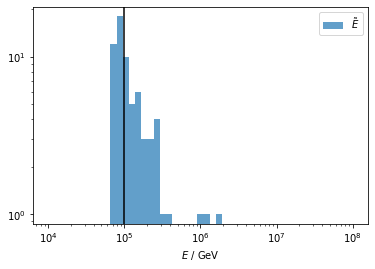

In [288]:
Esrc = simulation.extract(['Esrc'])['Esrc'][0]
E_sim = simulation.extract(['E'])['E'][0]
#Edet_sim = simulation.extract(['Edet'])['Edet'][0]
bins = 10**np.linspace(4, 8)

fig, ax = plt.subplots()
ax.hist(E_sim, bins=bins, label='$\\tilde{E}$', alpha=0.7);
#ax.hist(Edet_sim, bins=bins, label='$\hat{E}$', alpha=0.7);
ax.axvline(sim_inputs["Edet_min"], color='k')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E$ / GeV')
ax.legend();

In [289]:
len(Edet_sim)

104

## Fit

In [290]:
from python.backend.stan_generator import (ParametersContext, 
                                           TransformedParametersContext, ModelContext)
from python.backend.variable_definitions import ParameterDef, ParameterVectorDef

In [323]:
with StanFileGenerator("stan_files/simple_model") as simple_fit_gen:
    with FunctionsContext():
        _ = Include("utils.stan")
        _ = Include("vMF.stan")
        _ = Include("interpolation.stan")
        _ = Include("sim_functions.stan")
        ntd = NorthernTracksDetectorModel()
        F_conv = source.flux_model.spectral_shape.make_stan_flux_conv_func("flux_conv")
        spec_lpdf = source.flux_model.spectral_shape.make_stan_lpdf_func("spec_logpdf")
        
    with DataContext():
        N = ForwardVariableDef("N", "int")
        N_str = ["[", N, "]"]
        #Edet = ForwardVariableDef("Edet", "vector[N]")
        E = ForwardVariableDef("E", "vector[N]")
        Esrc_min = ForwardVariableDef("Esrc_min", "real")
        Esrc_max = ForwardVariableDef("Esrc_max", "real")
        D = ForwardVariableDef("D", "real")
        redshift = ForwardVariableDef("redshift", "real")        
        T = ForwardVariableDef("T", "real")

        Ngrid = ForwardVariableDef("Ngrid", "int")
        alpha_grid = ForwardVariableDef("alpha_grid", "vector[Ngrid]")
        integral_grid = ForwardVariableDef("integral_grid", "vector[Ngrid]")
        #Eg = ForwardVariableDef("E_grid", "vector[Ngrid]")
        #Pg = ForwardVariableDef("Pdet_grid", "vector[Ngrid]")
    
    with TransformedDataContext():
        Esrc = ForwardVariableDef("Esrc", "vector[N]")
        D_m = ForwardVariableDef("D_m", "real")
        D_m << D * 3.086e22
        Esrc << E * (1+redshift)
        StringExpression(["print(", Ngrid, ")"])
        StringExpression(["print(", N, ")"])
        
    with ParametersContext():
        L = ParameterDef("L", "real", 0.0, 1e55)
        alpha = ParameterDef("alpha", "real", 1.0, 4.0)
        #Esrc = ParameterVectorDef("Esrc", "vector", N_str, Esrc_min, Esrc_max)
        
    with TransformedParametersContext():
        F = ForwardVariableDef("F", "real")
        eps = ForwardVariableDef("eps", "real")
        Nex = ForwardVariableDef("Nex", "real")
        #E = ForwardVariableDef("E", "vector[N]")
        
        F << StringExpression([L, "/ (4 * pi() * pow(", D_m, ", 2))"])
        F << F * F_conv(alpha, Esrc_min, Esrc_max)
        eps << FunctionCall([alpha, alpha_grid, integral_grid, T], "get_eps_simple")
        Nex << F * eps
        #E << Esrc / (1+redshift)
        
    with ModelContext():
        
        lp = ForwardVariableDef("lp", "vector[N]")
        
        with ForLoopContext(1, N, "i") as i:
            lp[i] << 0
            #lp[i] << lp[i] + FunctionCall([F], "log")
            lp[i] << lp[i] + spec_lpdf(Esrc[i], alpha, Esrc_min, Esrc_max)
            #lp[i] << lp[i] + ntd.energy_resolution(E[i], Edet[i])
            #StringExpression([lp[i], " += log(interpolate(", 
            #                  Eg, ", ", Pg, ", ", E[i], "))"])
            StringExpression(["target += ", lp[i]])
            #StringExpression(["target += -", Nex])

    simple_fit_gen.generate_single_file()

In [324]:
model = stan_utility.compile_model(filename=simple_fit_gen.filename,
                                   include_paths=include_paths, 
                                   model_name="fit")

Using cached StanModel


In [325]:
inputs = {}
inputs["N"] = len(E_sim)
#inputs["Edet"] = Edet_sim
inputs["E"] = E_sim
inputs["redshift"] = sim_inputs["redshift"]
inputs["D"] = sim_inputs["D"]
inputs["Edet_min"] = sim_inputs["Edet_min"]
inputs["Esrc_min"] = sim_inputs["Esrc_min"]
inputs["Esrc_max"] = sim_inputs["Esrc_max"]

inputs["Ngrid"] = sim_inputs["Ngrid"]
inputs["alpha_grid"] = sim_inputs["alpha_grid"]
inputs["integral_grid"] = sim_inputs["integral_grid"]
inputs["E_grid"] = exposure_integral.energy_grid.value
inputs["Pdet_grid"] = np.array(exposure_integral.pdet_grid)[0] + 1e-20
inputs["T"] = sim_inputs["T"]

In [326]:
fit = model.sampling(data=inputs, iter=1000, chains=1, algorithm="NUTS")

## Check results

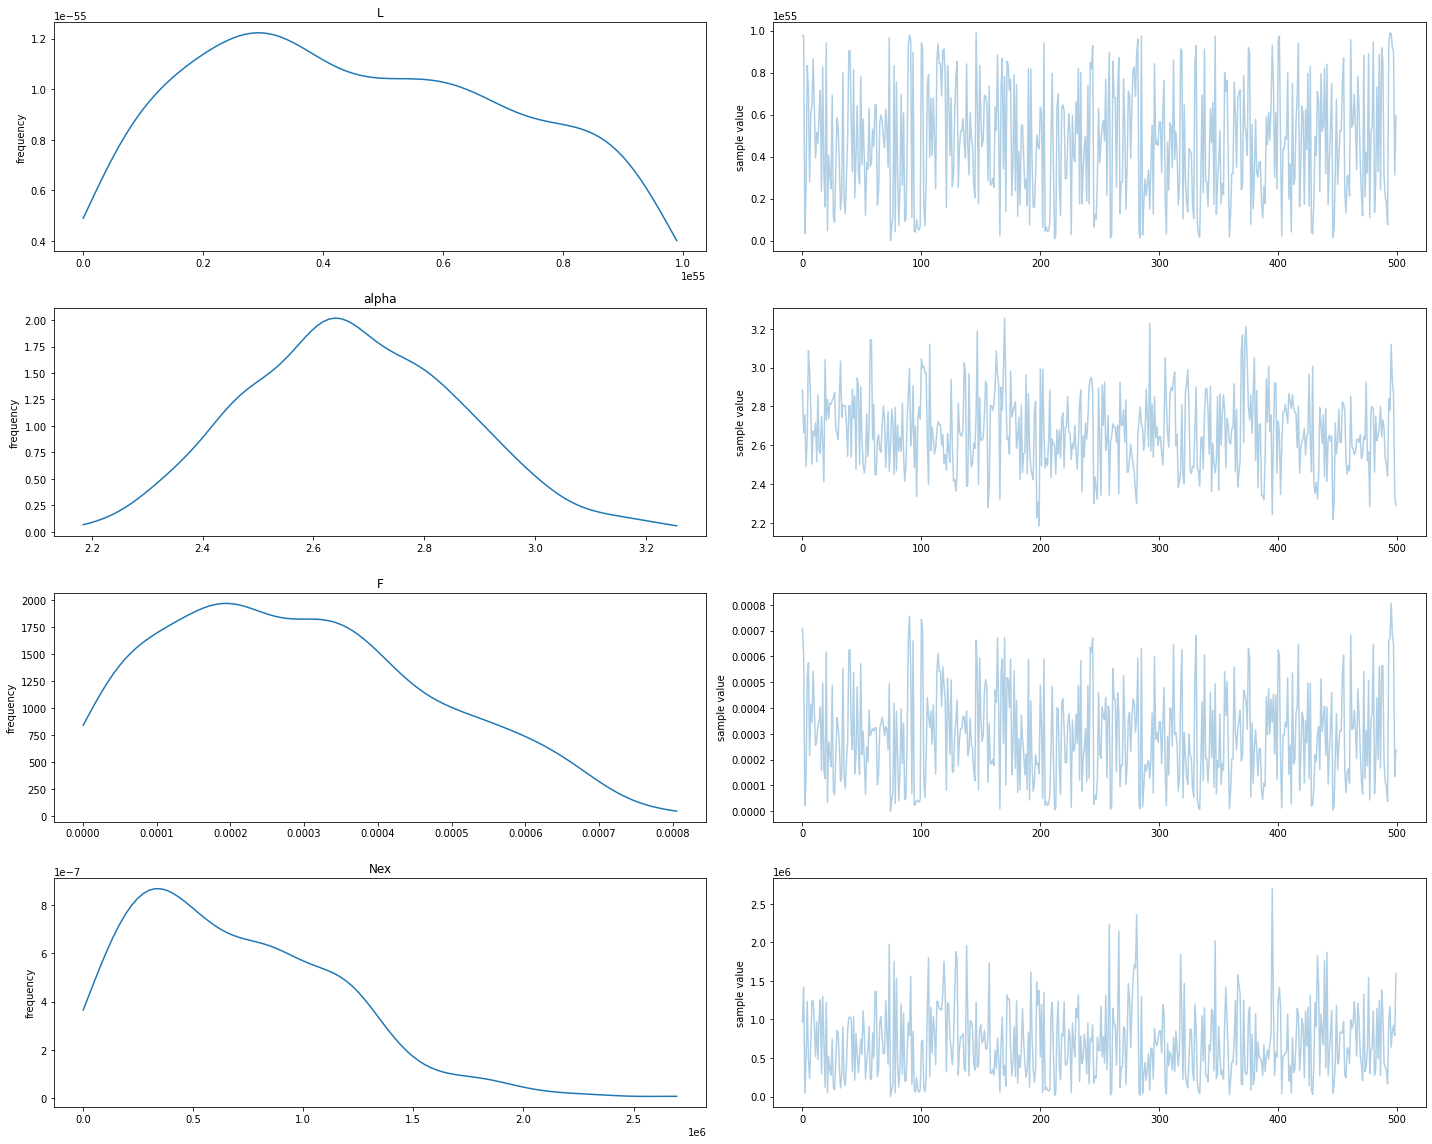

In [327]:
# View chains
fig = fit.plot([r'L', r'alpha', r'F', r"Nex"]);
fig.set_size_inches(20, 16)
fig.tight_layout()

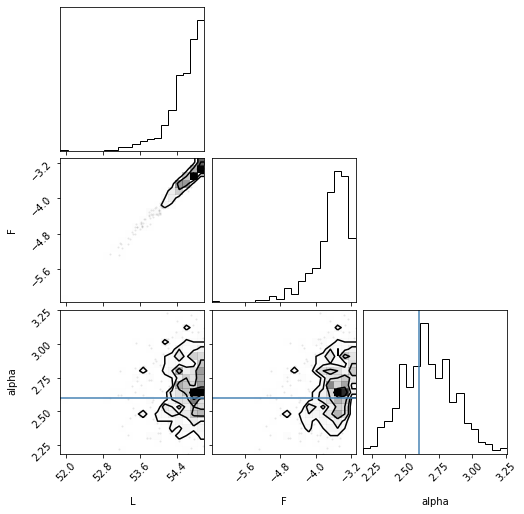

In [328]:
# View corner plot
chain = fit.extract(permuted = True)
key_list = ['L', 'F', 'alpha']
labels = [r'L', r'F', 'alpha']
truths = [np.log10(sim_inputs['L']), np.log10(source.flux_model.total_flux_int.value), 
          sim_inputs['alpha']]

corner.corner(np.column_stack([np.log10(chain['L']), np.log10(chain['F']),
                               chain['alpha']]),
              labels = labels, truths = truths);